In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
from transformers import AutoTokenizer, SiglipTextModel
import matplotlib.pyplot as plt

/home/jupyter-alton/miniconda3/envs/asgaard-movie-captions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Load fixed CSVs
df_0_5 = pd.read_csv("fixed_0.5b.csv")
df_7 = pd.read_csv("fixed_7b.csv")
df_sft = pd.read_csv("fixed_sft.csv")
df_updated = pd.read_csv("updated_file.csv")  # has 'Action' + 'Start' (Key Shot)

# 3. Action mapping for numbers (used in freeform outputs)
action_map_by_number = {
    "1": "Rescue",
    "2": "Escape",
    "3": "Capture",
    "4": "Heist",
    "5": "Fight",
    "6": "Pursuit",
    "7": "Speed",
    "8": "None"
}

# 4. Function to extract multiple action labels
def map_description_to_actions(desc):
    if pd.isna(desc):
        return "None"

    desc = str(desc).strip().lower()

    # Quick filter for noise
    if "no action found" in desc or "none of the above" in desc or "no action" in desc:
        return "None"

    actions_set = set()

    # Step 1: match keywords
    keyword_map = {
        "rescue": "Rescue",
        "escape": "Escape",
        "fight": "Fight",
        "capture": "Capture",
        "heist": "Heist",
        "pursuit": "Pursuit",
        "speed": "Speed"
    }

    for keyword, action in keyword_map.items():
        if keyword in desc:
            actions_set.add(action)

    # Step 2: match numbers like 1, 2, 3
    found_numbers = set(re.findall(r'\b[1-8]\b', desc))
    for number in found_numbers:
        mapped = action_map_by_number.get(number)
        if mapped and mapped != "None":
            actions_set.add(mapped)

    if not actions_set:
        return "None"

    return " and ".join(sorted(actions_set))

# 5. Apply mapping to all models
df_sft["Description sft"] = df_sft["Description"].astype(str)
df_7["Description"] = df_7["Description"].astype(str)
df_0_5["Description"] = df_0_5["Description"].astype(str)

df_sft["Mapped Action SFT"] = df_sft["Description sft"].apply(map_description_to_actions)
df_7["Mapped Action 7B"] = df_7["Description"].apply(map_description_to_actions)
df_0_5["Mapped Action 0.5B"] = df_0_5["Description"].apply(map_description_to_actions)
df_updated["Mapped Ground Truth"] = df_updated["Action"].fillna("None").astype(str).apply(map_description_to_actions)

# 6. Merge for comparison
df_merged = df_updated[["Start", "Mapped Ground Truth"]].rename(columns={"Start": "Key Shot"}).copy()
df_merged["Mapped Action SFT"] = df_sft["Mapped Action SFT"]
df_merged["Mapped Action 7B"] = df_7["Mapped Action 7B"]
df_merged["Mapped Action 0.5B"] = df_0_5["Mapped Action 0.5B"]

# 7. Preview the result
print(df_merged.head())
df_merged.to_csv("mapped_action_comparison.csv", index=False)

   Key Shot Mapped Ground Truth Mapped Action SFT Mapped Action 7B  \
0         0                None              None             None   
1      1009                None              None             None   
2      1130                None              None             None   
3      6124               Fight              None             None   
4      8406                None              None             None   

  Mapped Action 0.5B  
0               None  
1               None  
2               None  
3               None  
4               None  


In [4]:
def to_action_set(x):
    if pd.isna(x) or x.strip().lower() == "none":
        return set()
    return set(map(str.strip, x.split("and")))

# Convert all columns to sets of actions
gt_sets = df_merged["Mapped Ground Truth"].apply(to_action_set)
sft_sets = df_merged["Mapped Action SFT"].apply(to_action_set)
llava7_sets = df_merged["Mapped Action 7B"].apply(to_action_set)
llava0_sets = df_merged["Mapped Action 0.5B"].apply(to_action_set)

# Now compare set equality (order doesn't matter)
accuracy_sft = (sft_sets == gt_sets).mean()
accuracy_7b = (llava7_sets == gt_sets).mean()
accuracy_0_5b = (llava0_sets == gt_sets).mean()

# Print results
print(f"SFT Accuracy (set match)       : {accuracy_sft * 100:.2f}%")
print(f"LLaVA 7B Accuracy (set match)  : {accuracy_7b * 100:.2f}%")
print(f"LLaVA 0.5B Accuracy (set match): {accuracy_0_5b * 100:.2f}%")

SFT Accuracy (set match)       : 67.66%
LLaVA 7B Accuracy (set match)  : 61.62%
LLaVA 0.5B Accuracy (set match): 77.42%


In [6]:
df_merged = pd.read_csv("mapped_action_comparison.csv")

# Load model & tokenizer
model = SiglipTextModel.from_pretrained("google/siglip-base-patch16-224").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")

In [7]:
df_0_5["Description 0.5"] = df_0_5["Description"]
df_7["Description 7"] = df_7["Description"]
df_sft["Description sft"] = df_sft["Description"]

# Merge them all
merged_df = pd.concat([
    df_7["Description 7"],
    df_0_5["Description 0.5"],
    df_sft["Description sft"],
    df_updated["Action"]
], axis=1)

# Computing similarity 

In [10]:
# STEP 1: Load your fixed & cleaned files
df_0_5 = pd.read_csv("fixed_0.5b.csv")
df_7 = pd.read_csv("fixed_7b.csv")
df_sft = pd.read_csv("fixed_sft.csv")
df_updated = pd.read_csv("updated_file.csv")  # Ground truth

# Rename columns for compatibility with your friend's code
df_0_5["Description 0.5"] = df_0_5["Description"].astype(str)
df_7["Description 7"] = df_7["Description"].astype(str)
df_sft["Description sft"] = df_sft["Description"].astype(str)
df_updated["Action"] = df_updated["Action"].astype(str)

# Combine them all into a single DataFrame
merged_df = pd.concat([
    df_7["Description 7"],
    df_0_5["Description 0.5"],
    df_sft["Description sft"],
    df_updated["Action"]
], axis=1)

# STEP 2: Load SigLIP model and tokenizer
model = SiglipTextModel.from_pretrained("google/siglip-base-patch16-224").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")

# STEP 3: Calculate Cosine Similarity Loss
list_0_5, list_7, list_sft = [], [], []

for index, row in merged_df.iterrows():
    try:
        desc_inputs_7 = [str(row.get("Description 7", ""))]
        desc_inputs_0_5 = [str(row.get("Description 0.5", ""))]
        desc_inputs_action = [str(row.get("Action", ""))]
        desc_inputs_sft = [str(row.get("Description sft", ""))]

        # Tokenize all
        inputs_7 = tokenizer(desc_inputs_7, padding=True, truncation=True, return_tensors="pt").to("cuda")
        inputs_0_5 = tokenizer(desc_inputs_0_5, padding=True, truncation=True, return_tensors="pt").to("cuda")
        inputs_action = tokenizer(desc_inputs_action, padding=True, truncation=True, return_tensors="pt").to("cuda")
        inputs_sft = tokenizer(desc_inputs_sft, padding=True, truncation=True, return_tensors="pt").to("cuda")

        # Get embeddings
        feature_7 = model(**inputs_7).pooler_output[0].detach().flatten().reshape(1, -1)
        feature_0_5 = model(**inputs_0_5).pooler_output[0].detach().flatten().reshape(1, -1)
        feature_sft = model(**inputs_sft).pooler_output[0].detach().flatten().reshape(1, -1)
        feature_action = model(**inputs_action).pooler_output[0].detach().flatten().reshape(1, -1)

        # Compute cosine similarity loss
        similarity_0_5 = torch.nn.functional.cosine_similarity(feature_0_5, feature_action).item()
        similarity_7 = torch.nn.functional.cosine_similarity(feature_7, feature_action).item()
        similarity_sft = torch.nn.functional.cosine_similarity(feature_sft, feature_action).item()

        list_0_5.append(1 - similarity_0_5)
        list_7.append(1 - similarity_7)
        list_sft.append(1 - similarity_sft)

    except Exception as e:
        print(f"Error on row {index}: {e}")
        list_0_5.append(None)
        list_7.append(None)
        list_sft.append(None)

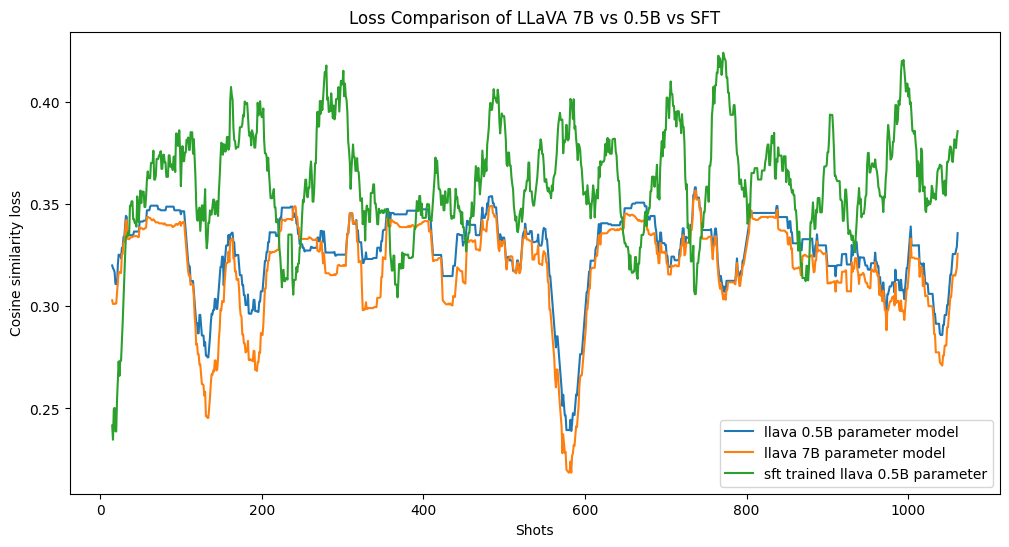

In [11]:
# Create DataFrame
loss_df = pd.DataFrame({
    "list_0_5": list_0_5,
    "list_7": list_7,
    "list_sft": list_sft
})

# Apply rolling mean smoothing
window = 30
loss_df["llava 0.5B parameter model"] = loss_df["list_0_5"].rolling(window=window, center=True).mean()
loss_df["llava 7B parameter model"] = loss_df["list_7"].rolling(window=window, center=True).mean()
loss_df["sft trained llava 0.5B parameter"] = loss_df["list_sft"].rolling(window=window, center=True).mean()

# Plot
loss_df[["llava 0.5B parameter model", "llava 7B parameter model", "sft trained llava 0.5B parameter"]].plot()
plt.gcf().set_size_inches(12, 6)
plt.xlabel("Shots")
plt.ylabel("Cosine similarity loss")
plt.title("Loss Comparison of LLaVA 7B vs 0.5B vs SFT")
plt.savefig("loss_analysis.png")
plt.show()

In [12]:
# Save rolling summary
loss_df.describe().to_csv("llm_summary_raw.csv")

summary_df = loss_df.describe()[[
    "llava 0.5B parameter model",
    "llava 7B parameter model",
    "sft trained llava 0.5B parameter"
]].transpose()[["mean", "std"]]

summary_df.columns = ["Mean Cosine Loss", "Standard Deviation Cosine Loss"]
summary_df.to_csv("llm_summary.csv")
print(summary_df)

                                  Mean Cosine Loss  \
llava 0.5B parameter model                0.326729   
llava 7B parameter model                  0.318808   
sft trained llava 0.5B parameter          0.361130   

                                  Standard Deviation Cosine Loss  
llava 0.5B parameter model                              0.020030  
llava 7B parameter model                                0.024313  
sft trained llava 0.5B parameter                        0.026961  


# data cleaning

In [14]:
df_sft = pd.read_csv("fixed_sft.csv")

In [15]:
import re

def normalize_description(text, word_cap=10):
    if pd.isna(text):
        return ""

    # Convert to string and strip
    text = str(text).strip().lower()

    # Remove repeating "no action found"
    text = re.sub(r"(no action found\s*)+", "no action found ", text)

    # Remove boilerplate prompts
    text = re.sub(r"classify the given video into the following actions.*?(?=\d)", "", text, flags=re.DOTALL)
    text = re.sub(r"your reply can include.*?example.*?\.", "", text, flags=re.DOTALL)

    # Remove long trailing numbers
    text = re.sub(r"(\d+\s*){10,}", "", text)

    # Remove overly repeated action words
    text = re.sub(r"(rescue\s*){5,}", "rescue ", text)
    text = re.sub(r"(escape\s*){5,}", "escape ", text)

    # Collapse all excessive whitespace
    text = re.sub(r"\s+", " ", text)

    # Keep only the first N words
    words = text.split()
    if len(words) > word_cap:
        text = " ".join(words[:word_cap])

    return text.strip()

In [16]:
df_sft["Normalized Description sft"] = df_sft["Description"].apply(lambda x: normalize_description(x, word_cap=10))

In [17]:
df_sft = df_sft.reset_index(drop=True)

In [18]:
print(df_sft)

      Key Shot                                        Description  \
0            0   No Action \n    10   For a Scene that Can hav...   
1         1009                                         No Action    
2         1130   No Action \n     A scene can have Rescue and ...   
3         6124   The video can have Rescue and Escape and figh...   
4         8406                                   No Action Found    
...        ...                                                ...   
1068    175033                                     Action 10\n      
1069    175223                                                  1   
1070    176198   None of the Above - For scenes that do not fa...   
1071    176291   You can also have a scene that has a Rescue a...   
1072    176298      The video can have Rescue and Escape.\n   ...   

                             Normalized Description sft  
0         no action 10 for a scene that can have rescue  
1                                             no action

In [19]:
# Save normalized merged dataframe
df_sft.to_csv("normalized_merged_descriptions.csv", index=False)

In [21]:
target_phrase = "the video can have rescue and escape. the video can"

# Function to apply replacement
def replace_specific_phrase(desc):
    desc = str(desc).lower().strip()
    if target_phrase in desc:
        return "No Action"
    return desc

# Apply to each normalized colum
df_sft["Description"] = df_sft["Description"].apply(replace_specific_phrase)

In [22]:
df_sft.to_csv("normalized_merged_descriptions.csv", index = False)

In [32]:
def strip_after_no_action(desc):
    if pd.isna(desc):
        return ""

    desc = str(desc).strip().lower()

    if "no action found" in desc:
        return "no action found"  # Keep only this phrase
    return desc  # Leave others untouched

# latest changes 

In [33]:
df = pd.read_csv("clean-final.csv")

In [34]:
def strip_after_no_action(desc):
    if pd.isna(desc):
        return ""

    desc = str(desc).strip().lower()

    if "no action found" in desc:
        return "no action found"  # Keep only this phrase
    return desc  # Leave others untouched

In [35]:
df["Description"] = df["Description"].apply(strip_after_no_action)

# Optional: Save cleaned output
df.to_csv("clean-final-latest.csv", index=False)

print("✅ Cleaned all trailing content after 'no action found'.")

✅ Cleaned all trailing content after 'no action found'.


# final analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, SiglipTextModel
import torch

/home/jupyter-alton/miniconda3/envs/asgaard-movie-captions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_0_5 = pd.read_csv("fixed_0.5b.csv")

In [3]:
df_7 = pd.read_csv("fixed_7b.csv")

In [4]:
df_ground = pd.read_csv("updated_file.csv")

In [5]:
df_sft = pd.read_csv("clean-final-latest.csv")

In [6]:
df_sft

,Key Shot,Description
0,0,no action
1,1009,no action
2,1130,no action
3,6124,fight
4,8406,no action found
...,...,...
1068,175033,action 10
1069,175223,no action found
1070,176198,no action found
1071,176291,no action found


In [7]:
df_sft["Description sft"] = df_sft["Description"].apply(lambda x: "None" if isinstance(x, str) and "no action" in x.lower() else x)

In [8]:
df_sft

,Key Shot,Description,Description sft
0,0,no action,None
1,1009,no action,None
2,1130,no action,None
3,6124,fight,fight
4,8406,no action found,None
...,...,...,...
1068,175033,action 10,action 10
1069,175223,no action found,None
1070,176198,no action found,None
1071,176291,no action found,None


In [9]:
df_sft["Description"].unique()

array(['no action', 'fight', 'no action found', 'escape', '1', 'capture',
       'capture fight', 'no answer', 'fight and escape',
       'the video can have rescue and escape.', 'rescue',
       'classify the given video into the following actions:',
       'no actionfound', 'man in black suit with bow tie and',
       'rescue 1. escape 2. capture 3. heist 4.', 'pursuit', 'heist',
       'the video can have escape and pursuit.',
       'the video can have rescue and escape. for',
       'action rescue escape escape escape escape escape escape',
       'this can be fight and escape',
       'the video can have fight and escape',
       'the video can have 2 or 3 or',
       'no action none of the 100 scene i',
       'no action - for a dramatic scene..', 'no rescue found',
       'classify the given video into the following actions',
       'the video contains the following categories: rescue, escape;',
       'man in suit with tie and suit with', '20', '2',
       'the video can have 

In [10]:
df_sft

,Key Shot,Description,Description sft
0,0,no action,None
1,1009,no action,None
2,1130,no action,None
3,6124,fight,fight
4,8406,no action found,None
...,...,...,...
1068,175033,action 10,action 10
1069,175223,no action found,None
1070,176198,no action found,None
1071,176291,no action found,None


In [11]:
df_7

,Key Shot,Description
0,0,NaN
1,1009,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
2,1130,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
3,6124,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
4,8406,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
...,...,...
1068,175033,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
1069,175223,None of the Above
1070,176198,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
1071,176291,None of the Above


In [12]:
df_ground

,Start,End,Start Time,End Time,Action
0,0,1008,00:00:00.000,00:00:40.320,No Action
1,1009,1129,00:00:40.360,00:00:45.160,No Action
2,1130,6123,00:00:45.200,00:04:04.920,No Action
3,6124,8405,00:04:04.960,00:05:36.200,fight
4,8406,8451,00:05:36.240,00:05:38.040,No Action
...,...,...,...,...,...
1071,176291,176297,01:57:31.640,01:57:31.880,No Action
1072,176298,176390,01:57:31.920,01:57:35.600,No Action
1073,176391,176397,01:57:35.640,01:57:35.880,No Action
1074,176398,176497,01:57:35.920,01:57:39.880,No Action


In [13]:
df_ground["Action"] = df_ground["Action"].replace(to_replace=["No Action", "No action", "no action", "No Action Found", "no action found"],value="None")

In [14]:
df_ground

,Start,End,Start Time,End Time,Action
0,0,1008,00:00:00.000,00:00:40.320,None
1,1009,1129,00:00:40.360,00:00:45.160,None
2,1130,6123,00:00:45.200,00:04:04.920,None
3,6124,8405,00:04:04.960,00:05:36.200,fight
4,8406,8451,00:05:36.240,00:05:38.040,None
...,...,...,...,...,...
1071,176291,176297,01:57:31.640,01:57:31.880,None
1072,176298,176390,01:57:31.920,01:57:35.600,None
1073,176391,176397,01:57:35.640,01:57:35.880,None
1074,176398,176497,01:57:35.920,01:57:39.880,None


In [15]:
df_ground["Action"] = df_ground["Action"].replace(to_replace=np.nan, value="None")

In [16]:
print(df_ground["Action"].value_counts())

Action
None                            850
fight                            77
capture                          28
escape                           22
rescue                           20
escape and rescue                10
speed                            10
pursuit                           9
escape and speed                  7
capture and fight                 5
escape and fight                  4
fight and escape                  3
speed and pursuit                 3
capture and rescue                2
pursuit and capture               2
pursuit and speed                 2
capture and escape                2
fight and capture                 2
heist                             2
capture and rescue and fight      1
rescue and heist                  1
speed and escape                  1
fight and pursuit                 1
capture and Fight                 1
escape and pursuit                1
escape and resuce                 1
pursuit and speed and fight       1
pursuit and rescue an

In [17]:
df_0_5["Description 0.5"] = df_0_5["Description"]

In [18]:
df_0_5

,Key Shot,Description,Description 0.5
0,0,The video contains a sequence of images with ...,The video contains a sequence of images with ...
1,1009,"A black screen with the words ""Batman"" in yel...","A black screen with the words ""Batman"" in yel..."
2,1130,The video contains a dark blue background wit...,The video contains a dark blue background wit...
3,6124,"The scene is dark and dimly lit, with a man i...","The scene is dark and dimly lit, with a man i..."
4,8406,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
...,...,...,...
1068,175033,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
1069,175223,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
1070,176198,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
1071,176291,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...


In [19]:
df_7["Description 7"] = df_7["Description"]

In [20]:
merged_df = pd.concat([df_7,df_0_5,df_sft,df_ground],axis=1)

In [21]:
merged_df

,Key Shot,Description,Description 7,Key Shot,Description,Description 0.5,Key Shot,Description,Description sft,Start,End,Start Time,End Time,Action
0,0.0,NaN,NaN,0.0,The video contains a sequence of images with ...,The video contains a sequence of images with ...,0.0,no action,None,0,1008,00:00:00.000,00:00:40.320,None
1,1009.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1009.0,"A black screen with the words ""Batman"" in yel...","A black screen with the words ""Batman"" in yel...",1009.0,no action,None,1009,1129,00:00:40.360,00:00:45.160,None
2,1130.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1130.0,The video contains a dark blue background wit...,The video contains a dark blue background wit...,1130.0,no action,None,1130,6123,00:00:45.200,00:04:04.920,None
3,6124.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,6124.0,"The scene is dark and dimly lit, with a man i...","The scene is dark and dimly lit, with a man i...",6124.0,fight,fight,6124,8405,00:04:04.960,00:05:36.200,fight
4,8406.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,8406.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,8406.0,no action found,None,8406,8451,00:05:36.240,00:05:38.040,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,176291.0,None of the Above,None of the Above,176291.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,176291.0,no action found,None,176291,176297,01:57:31.640,01:57:31.880,None
1072,176298.0,8,8,176298.0,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,176298.0,no action found,None,176298,176390,01:57:31.920,01:57:35.600,None
1073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176391,176397,01:57:35.640,01:57:35.880,None
1074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176398,176497,01:57:35.920,01:57:39.880,None


In [22]:
merged_df = merged_df[["Description 7","Description 0.5", "Description sft","Action"]]

In [23]:
merged_df

,Description 7,Description 0.5,Description sft,Action
0,NaN,The video contains a sequence of images with ...,None,None
1,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,"A black screen with the words ""Batman"" in yel...",None,None
2,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,The video contains a dark blue background wit...,None,None
3,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,"The scene is dark and dimly lit, with a man i...",fight,fight
4,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
...,...,...,...,...
1071,None of the Above,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
1072,8,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
1073,NaN,NaN,NaN,None
1074,NaN,NaN,NaN,None


# mapping values 

In [26]:
mapping_dict = {
    "1": "Rescue",
    "2": "Escape",
    "3": "Capture",
    "4": "Heist",
    "5": "Fight",
    "6": "Pursuit",
    "7": "Speed",
    "8": "None",
    "no action": "None",
    "no action found": "None",
    "no answer": "None",
    "classify the given video into the following actions:": "None",
    "no actionfound": "None",
    "man in black suit with bow tie and": "None",
    "rescue 1. escape 2. capture 3. heist 4.": "None",
    "action rescue escape escape escape escape escape escape": "None",
    "no action none of the 100 scene i": "None",
    "no action - for a dramatic scene..": "None",
    "no rescue found": "None",
    "classify the given video into the following actions": "None",
    "man in suit with tie and suit with": "None",
    "20": "None",
    "none of the above": "None",
    "10": "None",
    "no": "None",
    "no classify": "None",
    "no action - for a scene that does": "None",
    "no action #2 rescue #3 escape #4 heist": "None",
    "no classify - for scenes that do not": "None",
    "the video can have 3 categories if possible.": "None",
    "no action - for scenes that do not": "None",
    "no action for scene he of a man": "None",
    "no action for rescue he escape capture he": "None",
    "20 30 40 50 60 70 80 90": "None",
    "the video contains multiple categories.": "None",
    "action": "None",
    "none of the above - for scenes that": "None",
    "the video can have 3 categories if possible:": "None",
    "your reply can include multiple categories if possible.": "None",
    "the video can have 2 or 3. the": "None",
    "action 10": "None",
    "escape and rescue": "Rescue and Escape",
    "escape and resuce": "Rescue and Escape",
    "capture and fight": "Capture and Fight",
    "escape and fight": "Escape and Fight",
    "fight and escape": "Fight and Escape",
    "speed and pursuit": "Speed and Pursuit",
    "capture and rescue": "Capture and Rescue",
    "pursuit and capture": "Pursuit and Capture",
    "pursuit and speed": "Pursuit and Speed",
    "capture and escape": "Capture and Escape",
    "fight and capture": "Fight and Capture",
    "rescue and heist": "Rescue and Heist",
    "speed and escape": "Speed and Escape",
    "fight and pursuit": "Fight and Pursuit",
    "capture and Fight": "Capture and Fight",
    "escape and pursuit": "Escape and Pursuit",
    "pursuit and rescue": "Pursuit and Rescue",
    "fight and rescue": "Fight and Rescue",
    "speed and fight": "Speed and Fight",
    "rescue and capture": "Rescue and Capture", 
    "none and rescue": "None",
    "capture and rescue and fight": "Capture and Rescue and Fight",
    "pursuit and speed and fight": "Pursuit and Speed and Fight",
    "pursuit and rescue and fight": "Pursuit and Rescue and Fight",
    "speed and fight and pursuit": "Speed and Fight and Pursuit",
    "speed and fight and escape": "Speed and Fight and Escape",
    "0": "None",
    "a scene of capture and fight": "Capture and Fight",
    "capture": "Capture",
    "fight": "Fight",
    "escape": "Escape",
    "escape and speed": "Escape and Speed",
    "for a scene that includes rescue": "None",
    "heist": "Heist",
    "it can have a rescue and escape. a": "None",
    "pursuit": "Pursuit",
    "rescue": "Rescue",
    "rescue a scene can have escape. a scene": "Rescue and Escape",
    "rescue a scene can have rescue and escape.": "Rescue and Escape",
    "rescue a scene with a character in a": "Rescue",
    "rescue rescue rescue rescue rescue rescue rescue rescue": "Rescue",
    "speed": "Speed",
    "the action is capture and fight": "Capture and Fight",
    "the video can have 2 or 3 or": "None",
    "the video can have 2 or 4 scenes.": "None",
    "the video can have 3 categories: rescue, escape,": "None",
    "the video can have escape and pursuit.": "Escape and Pursuit",
    "the video can have escape and rescue.": "Escape and Rescue",
    "the video can have escape and speed. a": "Escape and Speed",
    "the video can have fight and escape": "Fight and Escape",
    "the video can have pursuit and speed and": "Pursuit and Speed",
    "the video can have rescue and escape.": "Rescue and Escape",
    "the video can have rescue and escape. a": "Rescue and Escape",
    "the video can have rescue and escape. for": "Rescue and Escape",
    "the video can have rescue and escape. the": "Rescue and Escape",
    "the video can have rescue. the video can": "Rescue",
    "the video can have speed and fight. a": "Speed and Fight",
    "the video contains multiple categories. for example, a": "None",
    "the video contains the following categories: rescue, escape,": "None",
    "the video contains the following categories: rescue, escape;": "None",
    "the video have fight.": "Fight",
    "this can be fight and escape": "Fight and Escape",
    "capture fight": "Capture and Fight", 
    "for a scene that includes rescue, you can": "Rescue",
    "the video can have 3 categories: rescue, escape,": "Rescue and Escape",
    "None": "None"
}

for entry in merged_df["Description 7"].unique():
    if entry not in mapping_dict:
        print(f"❌ Missing mapping for: '{entry}'")
    else:
        print(f"✅ Mapped: '{entry}' → '{mapping_dict[str(entry)]}'")

merged_df["Description 7"] = merged_df["Description 7"].apply(lambda x: mapping_dict.get(str(x), "None"))

❌ Missing mapping for: 'nan'
❌ Missing mapping for: '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
✅ Mapped: '4' → 'Heist'
✅ Mapped: '8' → 'None'
✅ Mapped: '1' → 'Rescue'
❌ Missing mapping for: '4. Heist'
✅ Mapped: '6' → 'Pursuit'
✅ Mapped: '3' → 'Capture'
❌ Missing mapping for: 'None of the Above'
❌ Missing mapping for: 'The video does not provide clear visual information to classify actions into specific categories such as "Rescue," "Escape," "Capture," "Heist," "Fight," "Pursuit," or "Speed."'
❌ Missing mapping for: '1. Res

/tmp/ipykernel_489774/465290997.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["Description 7"] = merged_df["Description 7"].apply(lambda x: mapping_dict.get(str(x), "None"))


In [27]:
print("✅ Final unique mapped values:", merged_df["Description 7"].unique())

✅ Final unique mapped values: ['None' 'Heist' 'Rescue' 'Pursuit' 'Capture']


In [41]:
merged_df

,Description 7,Description 0.5,Description sft,Action
0,None,The video contains a sequence of images with ...,None,None
1,None,"A black screen with the words ""Batman"" in yel...",None,None
2,None,The video contains a dark blue background wit...,None,None
3,None,"The scene is dark and dimly lit, with a man i...",fight,fight
4,None,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
...,...,...,...,...
1071,None,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
1072,None,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,None,None
1073,None,NaN,NaN,None
1074,None,NaN,NaN,None


In [42]:
from transformers import AutoTokenizer, SiglipTextModel

model = SiglipTextModel.from_pretrained("google/siglip-base-patch16-224").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")
list_0_5 = []
list_7 = []
list_sft = []
for index, row in merged_df.iterrows():
    desc_inputs_7 = [str(row.get("Description 7", ""))]
    desc_inputs_0_5 = [str(row.get("Description 0.5", ""))]
    desc_inputs_action = [str(row.get("Action", ""))]
    desc_sft = [str(row.get("Description sft",""))]
    inputs_7 = tokenizer(
        desc_inputs_7, 
        padding=True,  # Ensures batch processing
        truncation=True,  # Ensures inputs fit model's expected length
        return_tensors="pt"
    ).to("cuda")
    inputs_0_5 = tokenizer(
        desc_inputs_0_5, 
        padding=True,  # Ensures batch processing
        truncation=True,  # Ensures inputs fit model's expected length
        return_tensors="pt"
    ).to("cuda")
    inputs_action = tokenizer(
        desc_inputs_action, 
        padding=True,  # Ensures batch processing
        truncation=True,  # Ensures inputs fit model's expected length
        return_tensors="pt"
    ).to("cuda")
    inputs_sft = tokenizer(
        desc_sft, 
        padding=True,  # Ensures batch processing
        truncation=True,  # Ensures inputs fit model's expected length
        return_tensors="pt"
    ).to("cuda")
    outputs_7 = model(**inputs_7)
    feature_7 = outputs_7.pooler_output[0].detach().flatten().reshape(1,-1)
    outputs_0_5 = model(**inputs_0_5)
    feature_0_5 = outputs_0_5.pooler_output[0].detach().flatten().reshape(1,-1)
    outputs_action = model(**inputs_action)
    feature_action = outputs_action.pooler_output[0].detach().flatten().reshape(1,-1)
    outputs_sft = model(**inputs_sft)
    feature_sft = outputs_sft.pooler_output[0].detach().flatten().reshape(1,-1)
    similarity_0_5 = torch.nn.functional.cosine_similarity(feature_0_5,feature_action).item()
    similarity_7 = torch.nn.functional.cosine_similarity(feature_7,feature_action).item()
    similarity_sft = torch.nn.functional.cosine_similarity(feature_sft,feature_action).item()
    loss_0_5 = 1 - similarity_0_5
    loss_7 = 1 - similarity_7
    loss_sft = 1 - similarity_sft
    list_0_5.append(loss_0_5)
    list_7.append(loss_7)
    list_sft.append(loss_sft)

In [43]:
loss_df = pd.DataFrame({"list_0_5":list_0_5,"list_7":list_7, "list_sft":list_sft})
window = 30

In [31]:
loss_df["llava 0.5B parameter model"] = loss_df["list_0_5"].rolling(window=window, center=True).mean()

In [32]:
loss_df["llava 7B parameter model"] = loss_df["list_7"].rolling(window=window, center=True).mean()

In [33]:
loss_df["sft trained llava 0.5B parameter"] = loss_df["list_sft"].rolling(window=window, center=True).mean()

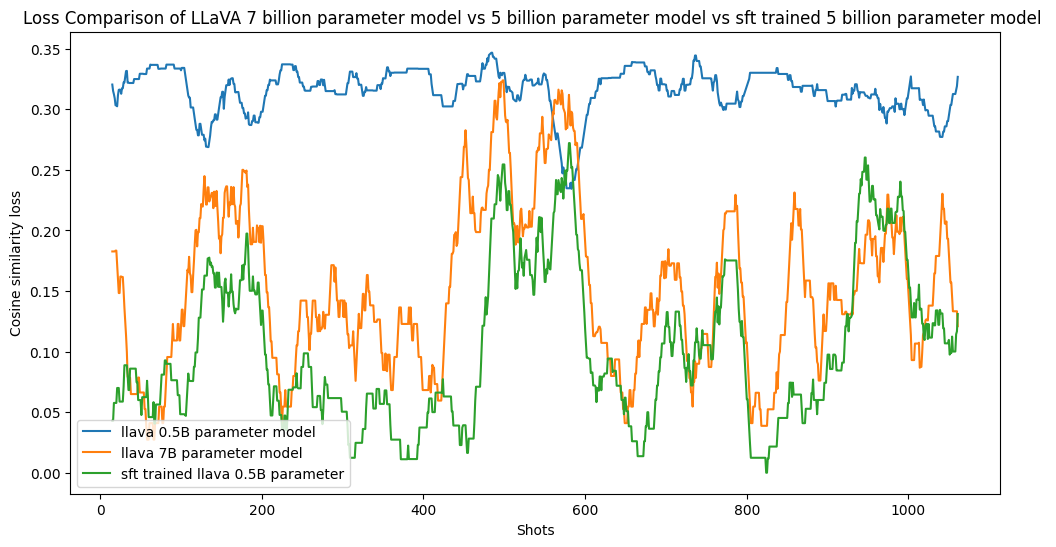

In [34]:

loss_df[["llava 0.5B parameter model","llava 7B parameter model","sft trained llava 0.5B parameter"]].plot()
plt.gcf().set_size_inches(12, 6)
plt.xlabel("Shots")
plt.ylabel("Cosine similarity loss")
plt.title("Loss Comparison of LLaVA 7 billion parameter model vs 5 billion parameter model vs sft trained 5 billion parameter model ")
plt.savefig("loss_analysis.png")

In [35]:
loss_df.describe().to_csv("llm_summary.csv")

In [36]:
summary_df = loss_df.describe()[["llava 0.5B parameter model","llava 7B parameter model","sft trained llava 0.5B parameter"]].transpose()[["mean","std"]]

In [37]:
summary_df

,mean,std
llava 0.5B parameter model,0.315609,0.018407
llava 7B parameter model,0.151941,0.066491
sft trained llava 0.5B parameter,0.102236,0.064161


In [38]:
summary_df["Mean Cosine Loss"] = summary_df["mean"] 

In [39]:
summary_df["Standard Deviation Cosine Loss"] = summary_df["std"]

In [40]:
summary_df[["Mean Cosine Loss","Standard Deviation Cosine Loss"]].to_csv("llm_summary.csv")